# Numerical Langevin
### By Carlos A.C.C. Perello

## Contents
0. [Preliminaries](#prelims)
1. [General computation of the derivative of the Brenier map](#brenier)
2. [Time-evolving computation the derivatives for the Brenier & Langevin maps](#langevin)
3. [Generating Models](#models)
4. [Properties of DS and DT](#properties)

## 0. Preliminaries <a class="anchor" id="prelims"></a>
The only preliminaries are importing the relevant packages, i.e. the `LinearAlgebra.jl` package.

In [81]:
using LinearAlgebra, Plots

## 1. General computation of the derivative of the Brenier map <a class="anchor" id="brenier"></a>

We are interested in transporting the following distributions:

$$
\mathcal{N}(m_1,\Sigma_1)\to\mathcal{N}(m_2, \Sigma_2)
$$

Where $\mathcal{N}(\mathbf{\mu}, \Sigma)$ is a multivariate normal with mean $\mathbf{\mu}\in \mathbb{R}^n$ and covariance matrix $\Sigma\in\mathbb{R}^{n\times n}$.

As we are interested in transporting a Gaussian distribution into another Gaussian distribution, the problem of computing the Brenier map (the unique map which is the gradient of a convex function, denoted as $T$) between these 2 distributions simplifies to computing the map [1]:

$$
T:x\mapsto m_2 + M(x-m_1) \quad \text{with } M = \Sigma_1^{-1/2}(\Sigma_1^{1/2}\Sigma_2\Sigma_1^{1/2})^{1/2}\Sigma_1^{-1/2}
$$

Therefore, the derivative of the Brenier map, $DT = M$, which is easy to compute and done below. We also want to compute the singular values of $DT$ as they can be used to bound its operator norm.

In [2]:
function DT(Σ₁, Σ₂)
    #=
    Returns a tuple consisting of 
    the derivative of the Bernier map in the first entry
    and a vector containing the singular vals
    of the derivative of the Bernier map in the second entry.
    =#
    ret = inv(√(Σ₁))*√(√(Σ₁)*Σ₂*√(Σ₁))*inv(√(Σ₁))
    ret
end

DT (generic function with 1 method)

#### Test

We generate 2 random pos. def matrices, which we will use for testing throughout the code.

In [3]:
n = 2 # Dimension of multivariate Gaussian
X₁ = rand(n, n)
X₂ = rand(n, n) # Generate 2 random n×n matrices
C₁ = X₁'*X₁
C₂ = X₂'*X₂ # Use the random matrices to generate 2 random 
# n×n pos. def. matrices, as covariance matrices are pos. def.
print(C₁)
print("\n")
print(C₂)

[0.5270796045046596 0.4279384063021557; 0.4279384063021557 0.7913664171583438]
[1.0591212626011977 0.8922524565146093; 0.8922524565146093 1.0241718831741855]

In [4]:
DT(C₁, C₂)

2×2 Matrix{Float64}:
 1.19004   0.256045
 0.256045  0.988345

## 2. Time-evolving computation the derivatives for the Brenier & Langevin maps <a class="anchor" id="langevin"></a>

### 2.1 Computing $B_t$



We want to numerically compute the Langevin map between two Gaussians. We note that in this case, we are transporting:
$$
\mu = \mathcal{N}(\mu_1,\, \Sigma_1) \to \nu = \mathcal{N}(\mu_2,\, \Sigma_1 + \Sigma_2)
$$

To do so, we first need to introduce $P_t^A(f) $ and $B_t$. We define $P_t^A(f)$ as [2]:
$$
P_t^A(f) = \int_{\mathbb{R^n}}f\left(\exp(-tA)x + \sqrt{\text{Id}-\exp(-2tA)} y\right)d\mu(y)
$$

In the case of transport between 2 gaussians, $B_t$ is then defined as [2]:
$$
P_t^A\left(c_o\exp\left(-\frac{1}{2}y^TBy\right)\right)(x) = c_t\exp\left(-\frac{1}{2}x^T B_t x\right)
$$
And $B_t$ can be computed by explicitly computing and rearranging the LHS of the equation above [2].
We introduce the notation $A=\Sigma_1$, $B=\Sigma_2, C = e^{-tA}, D=\sqrt{I-e^{-2tA}}$ and $W = \sqrt{D^TBD + A}$ to obtain that $B_t$ is:
$$
B_t = C^TBC - C^TBDW^{-1}W^{-T}D^TB^TC
$$
and $c_t$ is given by:
$$
c_t = \frac{cc_0\sqrt{\pi}}{2\left|\det(W)\right|}
$$

We can think of $B_t$ as the "intermediate transport" between the two covariances; take $\mu_1 = \mu_2 = 0$ for simplicity:
- $B_0 = \Sigma_2$
- $B_\infty = 0$
- The covariance of an "intermediate Gaussian", i.e. if we truncate transport $\mathcal{N}(0,\Sigma_1) \to \mathcal{N}(0, \Sigma_1 + \Sigma_2)$ at time $t$ our resulting Gaussian will be $\mathcal{N}(0, \Sigma_1 + B_t)$


We can implement $B_t$ and $c_t$ as functions, done below.

In [5]:
function Bₜ(Σ₁, Σ₂, t)
    C = exp(-t.*Σ₁)
    D = √(I-exp(-(2*t).*Σ₁))
    W = √(D'*Σ₂*D + Σ₁)
    prod = C'*Σ₂*D*inv(W)
    ret = C'*Σ₂*C - prod*prod'
    ret
end

function cₜ(c, c₀, Σ₁, Σ₂, t)
    D = √(I-exp(-(2*t).*Σ₁))
    W = √(D'*Σ₂*D + Σ₁)
    ret = (c*c₀*(√π))/(2*abs(det(W)))
    ret
end

cₜ (generic function with 1 method)

#### 2.1.1 Test

$B_t$ should satisfy $B_0 = B = \Sigma_2$ [2] which we can use as a sanity check. Additionally, tending $t\to\infty$ in the expression for $P^t_A(f)$ with our choice of $f$ yields that $B_\infty = \lim\limits_{t\to\infty}B_t = \log(\text{Id}) = \mathbf{0}_{2\times 2}$. To test this, we reuse the random positive definite matrices generated above:

In [6]:
Bₜ(C₁, C₂, 0) == C₂ && Bₜ(C₁, C₂, 10000000) == zeros(2, 2)

true

### 2.2 Derivative of Brenier map

Now let $\nu_t$ be the resulting measure transforming $\mu$ up to time step $t$. In this case, $\nu_0 = \nu$ and $\nu_\infty = \mu$. Let the Brenier map transporting $\mu\to\nu_t$ be $T_t$.

Then [2] tells us that the derivative of $T_t$ is given by:
$$
DT_t = \Sigma_1^{1/2}(\Sigma_1^{1/2}(\Sigma_1+B_t)\Sigma_1^{1/2})^{-1/2}\Sigma_1^{1/2}
$$
Which is implemented below.

In [7]:
function DTₜ(Σ₁, Σ₂, t)
    #= Map between μ and νₜ, where:
    μ = N(0, Σ₁)
    ν = N(0, Σ₁ + Σ₂)
    νₜ = N(0, Σ₁ + Bₜ) ⟹ ν₀ = ν, ν∞ = μ
    =#
    Bt = Bₜ(Σ₁, Σ₂, t)
    rootΣ₁ = √(Σ₁)
    ret = inv(rootΣ₁)*√(rootΣ₁*(Σ₁ + Bt)*rootΣ₁)*inv(rootΣ₁)
    ret
end

DTₜ (generic function with 1 method)

#### 2.2.1 Test

To test, we check that $DT_0$ indeed maps $\mu\to\nu$ and $DT_\infty$ indeed maps $\mu \to \mu$:

In [8]:
DTₜ(C₁, C₂, 0) ≈ DT(C₁, C₁ + C₂) && DTₜ(C₁, C₂, 100000) ≈ I

true

### 2.3 Derivative of Langevin map

Let $S_t(x)$ be the Langevin map at point $x$ at time $t$.

Then, once we have $B_t$, the Langevin map is given by solving the following PDE:
$$
\frac{\partial S_t(x)}{\partial t} = B_t S_t(x)
$$

Fixing $x$, this becomes:

$$
\frac{d S_t(x)}{dt} = B_t S_t(x)
$$

Which we can solve using a basic ODE solver, such as the Forward Euler method [3].

#### 2.3.1 Langevin map via Forward Euler


We now fix $x$ and solve for $S_t(x)$. As we fix $x$, it will be easier to write $S_t(x) = S_x(t)$. We first discretise the time dimension into $n$ equal sized time steps between 0 and $T$.

In [9]:
T = 10
n = 10_000
t = range(0, T, length=n)
h = step(t)

0.001000100010001

Now, we use the Forward Euler method, given by the following equation, to solve for $S_x(t)$:
$$
S_x(0) = x,\, \text{ as } t_1 = 0\\
S_x(t_{k+1}) = \left(\text{Id} + hB_{t_k}\right)S_x(t_{k}),\, 2\leq k\leq n
$$
This is implemented below as a function that takes in $x$ as its initial condition and outputs the time evolution of the Langevin map for the discrete time steps betwen $t=0$ and $t=T$.

In [10]:
function S(Σ₁, Σ₂, n, T, x, full=false)
    # full=True returns array of time evolution, if false just returns value at end T
    t = range(0, T, length=n)
    h = step(t)
    if full
        Sₜx = zeros(2, n)
        Sₜx[:, 1] = x
        for k = 1:n-1
            Sₜx[:, k+1] = (I + h.*Bₜ(Σ₁, Σ₂, t[k]))*Sₜx[:, k]
        end
    else
        Sₜx = x
        for k = 1:n-1
            Sₜx = (I + h.*Bₜ(Σ₁, Σ₂, t[k]))*Sₜx
        end
    end
    Sₜx
end

S (generic function with 2 methods)

#### 2.3.2 Derivative of Langevin map using Forward Euler

We can also solve for the derivative, $DS_x(t)$, by using solving the following differential equation:
$$
\frac{dDS_x(t)}{dt} = B_tDS_t(x);\; DS_x(0) = \text{Id}
$$

Note that as $DS_x(0)$ is independent of $x \, \forall x\in \mathbb{R^2}$, $DS_x(t)$ will be independent of $x$ too, meaning we can simply write $DS_x(t) = DS(t)$.

We can do this by extending Forward Euler to solve matrix ODEs; we have:
$$
DS(0) = \text{Id},\, \text{ as } t_1 = 0\\
DS(t_{k+1}) = \left(\text{Id} + hB_{t_k}\right)DS(t_{k}),\, 2\leq k\leq n
$$

This is implemented below. Note that we define `gen_step` to generate a nonuniformly spaced discretization of time; this is done to replicate the numerical methods implemented in [2] which yielded accurate results.

In [11]:
function gen_step(T, tol=0.001)
    if T <= 0.1
        ret = 0:0.02*tol:T
    elseif T <= 0.5 && T > 0.1
        ret = [0:0.02*tol:0.1; 0.1:0.05*tol:T]
    elseif T <= 1 && T > 0.5
        ret = [0:0.02*tol:0.1; 0.1:0.05*tol:0.5; 0.5:0.2*tol:T]
    elseif T <= 3 && T > 1
        ret = [0:0.02*tol:0.1; 0.1:0.05*tol:0.5; 0.5:0.2*tol:1; 1:0.5*tol:T]
    elseif T <= 5 && T > 3
        ret = [0:0.02*tol:0.1; 0.1:0.05*tol:0.5; 0.5:0.2*tol:1; 1:0.5*tol:3; 3:2*tol:T]
    else
        ret = [0:0.02*tol:0.1; 0.1:0.05*tol:0.5; 0.5:0.2*tol:1; 1:0.5*tol:3; 3:2*tol:5; 5:5*tol:T]
    end
end

gen_step (generic function with 2 methods)

In [12]:
#=
function DS_uniform(Σ₁, Σ₂, h, T)
    t = 0:h:T
    n = length(t)
    S∞ = [1 0; 0 1]
    for k = 1:n-1
        S∞ = (I + h.*Bₜ(Σ₁, Σ₂, t[k]))*S∞
    end
    S∞
end
=#
function DS(Σ₁, Σ₂, T, tol=0.0001)
    #= Numerically compute the derivative of the Langevin map
    between μ = N(0, Σ₁) -> ν = N(0, Σ₁ + Σ₂) (at time ∞)
    Parameters:
    - Σ₁, Σ₂: Covariance matrices.
    - T: Last time when the Fwd. Euler method is applied.
    - tol: Order of magnitude to which we want to approximate DS to the actual value. 
           Default 0.0001 ⟹ using [2]'s inhomogeneous time spacing.
    - conv: If the norm of the difference of subsequent iterations is below this value,
            we stop. Default 0 ⟹ we finish until end of iteration.
    =#
    realtol = tol*10
    t = gen_step(T, realtol)
    n = length(t)
    S∞ = I
    hold = I
    for k = 1:n-1
        hold = S∞
        h = t[k+1] - t[k]
        S∞ = (I + h.*Bₜ(Σ₁, Σ₂, t[k]))*S∞
    end
    S∞
end

DS (generic function with 2 methods)

We can now use the function above to implement a "binary search" on the space of matrices to find a stable approximation of $DS$, done below:

In [13]:
function DS_approx(Σ₁, Σ₂, stab, rate=1.1)
    T = 50
    mag = 0.0001
    S₁ = I
    S₂ = DS(Σ₁, Σ₂, T, mag)
    while norm(S₂ - S₁) >= stab
        T = ceil(rate*T)
        print("Iteration finished, mag=")
        println(mag)
        print("T=")
        println(T)
        print("Stop=")
        println(norm(S₂ - S₁))
        mag = mag/2
        S₁ = S₂
        S₂ = DS(Σ₁, Σ₂, T, mag)
    end
    S₂, Int64(T), mag
end

DS_approx (generic function with 2 methods)

#### 2.3.3 Test

We test our code by taking $\Sigma_1$ to be diagonal so it commutes with $\Sigma_2$. Once again, according to [2], if $\Sigma_1$ and $\Sigma_2$ commute, $\lim\limits_{t\to\infty}DS(t) = DT_0$. (more on why)

In [14]:
D₁ = Diagonal([5, 19, 20])
D₂ = Diagonal([19, 42, 30])

3×3 Diagonal{Int64, Vector{Int64}}:
 19   ⋅   ⋅
  ⋅  42   ⋅
  ⋅   ⋅  30

In [15]:
T = 30 # take T to be large to be an ok approximation of ∞ but small so we can converge in "fast-ish" time.
DScomm = DS(D₁, D₂, T, 1e-4) # the more we decrease h the better the approx, but the longer the wait

3×3 Diagonal{Float64, Vector{Float64}}:
 2.19125   ⋅        ⋅ 
  ⋅       1.79238   ⋅ 
  ⋅        ⋅       1.58153

In [16]:
norm(DTₜ(D₁, D₂, 0) - DScomm)

0.000787347081747445

As we know $DT_0$ yields the correct result in this case, we can test `DS_approx`

In [17]:
ds = DS_approx(D₁, D₂, 1e-4, 2)[1]

Iteration finished, mag=0.0001
T=100
Stop=1.5443810216751663
Iteration finished, mag=5.0e-5
T=200
Stop=0.00039371692912379506
Iteration finished, mag=2.5e-5
T=400
Stop=0.00019682592723057902


3×3 Diagonal{Float64, Vector{Float64}}:
 2.19094   ⋅        ⋅ 
  ⋅       1.79187   ⋅ 
  ⋅        ⋅       1.58119

In [18]:
norm(Matrix(ds) - DTₜ(D₁, D₂, 0))

9.839939956603449e-5

In [25]:
H = randn(5,5)
J = randn(5,5)
H2 = H*H'
J2 = J*J'


5×5 Matrix{Float64}:
  3.54697   -1.7968     0.983019   1.18285    0.506079
 -1.7968     4.03841    0.446761  -3.35471   -2.25849
  0.983019   0.446761   3.18718   -0.569011  -0.642516
  1.18285   -3.35471   -0.569011   4.08584    2.25599
  0.506079  -2.25849   -0.642516   2.25599    1.66981

In [28]:
M, T, stop = DS_approx(H2, J2, 1e-4, 4)

Iteration finished, mag=0.0001
T=200
Stop=1.9712099368618163
Iteration finished, mag=5.0e-5
T=800
Stop=0.00022004535335840936
Iteration finished, mag=2.5e-5
T=3200
Stop=0.00011000787312305478


([1.2015375168641096 -0.06107235243555013 … 0.10879903580263106 0.029406113049812208; -0.09443039337879093 1.2432771691778168 … -0.4088748384322416 -0.16988107581418008; … ; 0.22376071249258897 -0.49070689008395885 … 2.1889041507566236 0.33987715260765045; 0.04560426484912763 -0.1538295117365941 … 0.23355919973407552 1.178110686355072], 3200, 1.25e-5)

### Brainstorm

One first guess for the Langevin map was:
$$
G_1(t) = \sqrt{(\Sigma_1+B_t)\Sigma_1^{-1}}
$$
Which works when $\Sigma_1$ and $\Sigma_2$ commute, as in that case $G_1$ is the Brenier map. However, this is not the case for general $\Sigma_1$ and $\Sigma_2$ as verified below.

In [20]:
function G₁(Σ₁, Σ₂, t)
    ret = √((Σ₁+Bₜ(Σ₁, Σ₂, t))*inv(Σ₁))
    ret
end

norm(G₁(C₁, C₂, 30) - DS(C₁, C₂, 30)) ≈ 0 # not close to 0

false

Another guess would be to do the following:
- Let $\Sigma_1 = P D P^T $ and $\Sigma_1 + B_t = P_t D_t P_t^T$.


Then the guess is:
$$
G_2(t) = P_t(D_t D^{-1})^{1/2}P^T
$$

  

In [21]:
function G₂(Σ₁, Σ₂, t)
    Bt = Bₜ(Σ₁, Σ₂, t) # Compute Bₜ
    evals, P = eigen(Σ₁) # Decompose Σ₁
    evalsₜ, Pₜ = eigen(Σ₁+Bt) # Decompose Σ₁ + Bₜ
    D = Diagonal(evals) # Make Diagonal matrix of evals of Σ₁
    Dₜ = Diagonal(evalsₜ) # Make Diagonal matrix of evals of Σ₁ + Bₜ
    ret = Pₜ*√(Dₜ*inv(D))*P' # return the guess
    ret
end

G₂ (generic function with 1 method)

This does not seem to yield a good approximation either. However, this is observed:

In [ ]:
norm(G₂(D₁, D₂, 30) - DS_approx(D₁, D₂, 1e-5))

1.4787203749737685

One more guess is given by:
$$
G_3 = \sqrt{(\Sigma_1+\Sigma_2)\Sigma_1^{-1}}
$$


In [23]:
function G₃(Σ₁, Σ₂)
    ret = √((Σ₁+Σ₂)*inv(Σ₁))
    ret
end

G₃ (generic function with 1 method)

In [20]:
norm(G₃(D₁, D₂) - DS_approx(D₁, D₂, 1e-5))

LoadError: UndefVarError: G₃ not defined

### 2.4 Non-commuting $\Sigma_1$ and $\Sigma_2$

Consider the case where we transport $$\mu = \mathcal{N}(0, \Sigma_1) \to \nu = \mathcal{N}(0, \Sigma_1 + \Sigma_2)$$

We now explore the case when $\Sigma_1$ and $\Sigma_2$ do not commute. We first ask the question: Can we find noncommuting $\Sigma_1$ and $\Sigma_2$ such that $DT_0 = DS_\infty$? We first implement a function to generate a random noncommuting pair of matrices.

In [17]:
function gen_pd_pair(d, mode="normal")
    if mode == "normal"
        gen_scheme = n -> randn(n, n)
    elseif mode == "integer"
        gen_scheme = n -> rand(-10:10,(n,n))
    else
        return "err"
    end

    A₁ = gen_scheme(d)
    A₂ = gen_scheme(d)
    S₁ = A₁'*A₁
    S₂ = A₂'*A₂
    S₁, S₂
end

function gen_noncommuting_pair(d, mode="normal")
    if mode == "normal"
        gen_scheme = n -> randn(n, n)
    elseif mode == "integer"
        gen_scheme = n -> rand(-3:3, (n, n))
    else
        return "err"
    end
    A₁ = gen_scheme(d)
    A₂ = gen_scheme(d)
    S₁ = A₁'*A₁
    S₂ = A₂'*A₂
    while S₁*S₂ ≈ S₂*S₁
        A₁ = gen_scheme(d)
        A₂ = gen_scheme(d)
        S₁ = A₁'*A₁
        S₂ = A₂'*A₂
    end
    S₁, S₂
end

gen_noncommuting_pair (generic function with 2 methods)

## 3. Generating Models <a class="anchor" id="models"></a>

We now want to know what value of $T$, the time horizon and $h$, the step size, we must use for matrices of different dimensions and different stability tolerances. We start by defining a class called `TransportModel`:

In [21]:
Base.@kwdef mutable struct TransportModel
    d::Integer
    stab::Float64
    sampling::String
    mag::Float64 = 0.0
    T::Integer = 0
    growth_rate::Float64 = 1.1
end

TransportModel

Now we can run tests to see when `DS_approx` converges and at what values of $T$ and $h$ this occurs; we save this as a `TransportModel` which we will use to evaluate `DS` after:

In [22]:
function define_model(d, stab, sampling="normal", growth_rate=1.1)
    A, B = gen_noncommuting_pair(d, sampling)
    if sampling == "normal"
        B = 10*B
    end
    _, T, mag = DS_approx(A, B, stab, growth_rate)
    ret = TransportModel(d=d, stab=stab, sampling=sampling, mag=mag, T=T, growth_rate=growth_rate)
    ret
end

define_model (generic function with 3 methods)

We compute the different $h$ s and $T$ s for different stability bounds, dimensions and sampling methods and save them:

In [37]:
model_1em4_normal_2d = define_model(2, 1e-4, "normal")
model_1em5_normal_2d = define_model(2, 1e-5, "normal")

Iteration finished, mag=0.0001
T=56.0
Stop=3.4799045912176614
Iteration finished, mag=5.0e-5
T=62.0
Stop=0.0006398399617801026
Iteration finished, mag=2.5e-5
T=69.0
Stop=0.00031987352473299873
Iteration finished, mag=1.25e-5
T=76.0
Stop=0.00015992514702414278
Iteration finished, mag=0.0001
T=56.0
Stop=13.733921021541546
Iteration finished, mag=5.0e-5
T=62.0
Stop=0.0034009726557236012
Iteration finished, mag=2.5e-5
T=69.0
Stop=0.0017001079751174798
Iteration finished, mag=1.25e-5
T=76.0
Stop=0.0008499589680806701
Iteration finished, mag=6.25e-6
T=84.0
Stop=0.0004249557009907296
Iteration finished, mag=3.125e-6
T=93.0
Stop=0.0002124719095224587
Iteration finished, mag=1.5625e-6
T=103.0
Stop=0.00010623448619840054
Iteration finished, mag=7.8125e-7
T=114.0
Stop=5.3116912730017764e-5
Iteration finished, mag=3.90625e-7
T=126.0
Stop=2.6558454097181676e-5
Iteration finished, mag=1.953125e-7
T=139.0
Stop=1.3279366871837285e-5


TransportModel(2, 1.0e-5, "normal", 9.765625e-8, 139, 1.1)

In [38]:
println(model_1em4_normal_2d)
println(model_1em5_normal_2d)

TransportModel(2, 0.0001, "normal", 6.25e-6, 76, 1.1)
TransportModel(2, 1.0e-5, "normal", 9.765625e-8, 139, 1.1)


In [48]:
model_1em4_integer_2d = define_model(2, 1e-4, "integer")
model_1em5_integer_2d = define_model(2, 1e-5, "integer")

Iteration finished, mag=0.0001 T=56.0 stop=2.614117719599036Iteration finished, mag=5.0e-5 T=62.0 stop=0.00033624805898456233Iteration finished, mag=2.5e-5 T=69.0 stop=0.00016809902430298663Iteration finished, mag=0.0001 T=56.0 stop=12.32707559036681Iteration finished, mag=5.0e-5 T=62.0 stop=0.0022728191945257906Iteration finished, mag=2.5e-5 T=69.0 stop=0.0008992502772816411Iteration finished, mag=1.25e-5 T=76.0 stop=0.00043562453967957107Iteration finished, mag=6.25e-6 T=84.0 stop=0.00011033384928925767Iteration finished, mag=3.125e-6 T=93.0 stop=2.6025460600232657e-5Iteration finished, mag=1.5625e-6 T=103.0 stop=1.1102344975272849e-5Iteration finished, mag=7.8125e-7 T=114.0 stop=1.6347558974853195e-5Iteration finished, mag=3.90625e-7 T=126.0 stop=1.2455394507084549e-5

TransportModel(2, 1.0e-5, "integer", 1.953125e-7, 126)

In [49]:
println(model_1em4_integer_2d)
println(model_1em5_integer_2d)

TransportModel(2, 0.0001, "integer", 1.25e-5, 69)
TransportModel(2, 1.0e-5, "integer", 1.953125e-7, 126)


In [34]:
model_1em4_normal_5d = define_model(5, 1e-4, "normal", 3)

Iteration finished, mag=0.0001
T=150
Stop=15.781329000407695
Iteration finished, mag=5.0e-5
T=450
Stop=0.008114268507840644
Iteration finished, mag=2.5e-5
T=1350
Stop=0.004055550575503193
Iteration finished, mag=1.25e-5
T=4050
Stop=0.0020273782903945407


LoadError: InterruptException:

In [50]:
model_1em5_normal_5d = define_model(5, 1e-5, "normal", 2)

Iteration finished, mag=0.0001 T=56.0 stop=94.30399513630371Iteration finished, mag=5.0e-5 T=62.0 stop=4.849028140990339Iteration finished, mag=2.5e-5 T=69.0 stop=4.54656994584501Iteration finished, mag=1.25e-5 T=76.0 stop=4.974408113866221Iteration finished, mag=6.25e-6 T=84.0 stop=4.663872711034965Iteration finished, mag=3.125e-6 T=93.0 stop=5.003489917636702Iteration finished, mag=1.5625e-6 T=103.0 stop=5.269910043492717Iteration finished, mag=7.8125e-7 T=114.0 stop=5.473031597723034Iteration finished, mag=3.90625e-7 T=126.0 stop=5.621717246455759Iteration finished, mag=1.953125e-7 T=139.0 stop=5.723594585913815Iteration finished, mag=9.765625e-8 T=153.0 stop=5.785090881030983Iteration finished, mag=4.8828125e-8 T=169.0 stop=5.811592855780343Iteration finished, mag=2.44140625e-8 T=186.0 stop=6.180771989341907Iteration finished, mag=1.220703125e-8 T=205.0 stop=6.098498243414036

LoadError: InterruptException:

In [ ]:
println(model_1em4_normal_5d)
println(model_1em5_normal_5d)

In [ ]:
model_1em4_integer_5d = define_model(5, 1e-4, "integer")
model_1em5_integer_5d = define_model(5, 1e-5, "integer")

In [ ]:
println(model_1em4_integer_5d)
println(model_1em5_integer_5d)

In [ ]:
println(twod_models_normal)
println(twod_models_integer)
println(fived_models_normal)
println(fived_models_integer)

### Results

Here are the results from finding the correct spacing and end time:

In [64]:
model_1em4_integer_2d = TransportModel(2, 0.0001, "integer", 1.25e-5, 69, 1.1)
model_1em5_integer_2d = TransportModel(2, 1.0e-5, "integer", 1.953125e-7, 126, 1.1)
model_1em4_normal_2d = TransportModel(2, 0.0001, "normal", 6.25e-6, 76, 1.1)
model_1em5_normal_2d = TransportModel(2, 1.0e-5, "normal", 9.765625e-8, 139, 1.1)

TransportModel(2, 1.0e-5, "normal", 9.765625e-8, 139, 1.1)

Now we make a function `DS_Tmodel` that takes in $\Sigma_1$ and $\Sigma_2$ and a `TransportModel`, and then computes $DS$ without checking for stability, as this has been checked before.

In [27]:
function DS_Tmodel(Σ₁, Σ₂, model::TransportModel)
    if model.d != size(Σ₁)[1]
        return "error, incorrect model dimension size"
    end
    ret = DS(Σ₁, Σ₂, model.T, model.mag)
    ret
end


DS_Tmodel (generic function with 1 method)

And we define functions for said models:

In [97]:
DS_1em4_integer_2d = (MatPair) -> DS_Tmodel(MatPair[1], MatPair[2], model_1em4_integer_2d)
DS_1em5_integer_2d = (MatPair) -> DS_Tmodel(MatPair[1], MatPair[2], model_1em5_integer_2d)
DS_1em4_normal_2d = (MatPair) -> DS_Tmodel(MatPair[1], MatPair[2], model_1em4_normal_2d)
DS_1em5_normal_2d = (MatPair) -> DS_Tmodel(MatPair[1], MatPair[2], model_1em5_normal_2d)
DT₀_pair = (MatPair) -> DTₜ(MatPair[1], MatPair[2], 0)
#norm(DS_1em5_normal_2d([T₁,T₂]) - DTₜ_pair([T₁, T₂], 0))

#125 (generic function with 1 method)

## Generating a lot of matrices
We generate a lot of matrices to test hypotheses. Only $10^{-4}$ precision is achievable due to computation time.

In [76]:
normal_bundle_2d = [gen_pd_pair(2, "normal") for i in 1:100];
integer_bundle_2d = [gen_pd_pair(2, "integer") for i in 1:100];

Define function to get max singular value, aka the matrix's Lipschitz constant. We will use this to make our histogram:

In [77]:
maxsvdval = mat -> svdvals(mat)[1]

#115 (generic function with 1 method)

In [79]:
lip_c_normal_1em4_2d = maxsvdval.(DS_1em4_normal_2d.(normal_bundle_2d))

100-element Vector{Float64}:
  5.979004036698649
  2.055861803985211
  2.844718667667798
  1.1811442349782708
  2.214111697785423
  1.9274351982171603
  1.1264805341080943
  1.7981364194970242
  5.133869395850358
  3.3046002146198483
  1.3739259802115147
  7.217126339539078
  3.2632572077258124
  ⋮
  2.9268265980086
  1.0551272009827437
  1.7292348536229887
  1.7428404699555111
  1.066663546896591
  2.2630759845256314
  6.888689224930343
  4.540512619710955
 14.872378913737013
  4.377726795879413
  1.3799446843818464
  7.816143759890379

In [120]:
DT₀_lip_c_normal_1em4_2d = maxsvdval.(DT₀_pair.(normal_bundle_2d))

100-element Vector{Float64}:
  5.9314598540985335
  2.055849165401997
  3.155798738463483
  1.1787384100574336
  2.2071372046633266
  1.9012061892117866
  1.1255266645840345
  1.7964587784413222
  4.837809489690297
  3.255786795808689
  1.3675856957299586
  6.857703625673929
  3.2582371721513868
  ⋮
  2.9103066674922795
  1.055113172167065
  1.7220275161978231
  1.7188872717302512
  1.0666588978708627
  2.2367174036146875
  6.7044119110601885
  4.53542837236019
 15.671434689860584
  4.277952966293692
  1.3798613801409914
  9.001544945169144

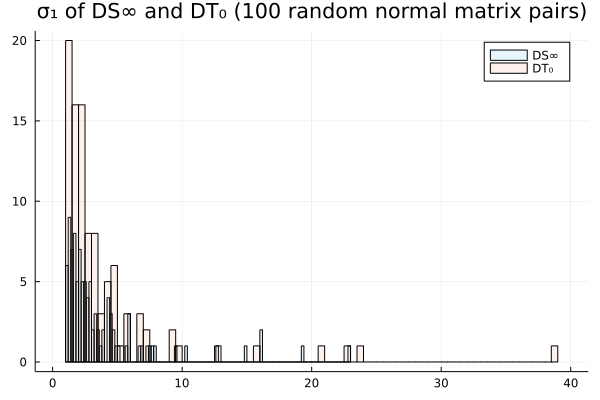

In [117]:
histogram(Any[lip_c_normal_1em4_2d, DT₀_lip_c_normal_1em4_2d], label=["DS∞" "DT₀"], nbins=[100 100], fillalpha=0.1, title="σ₁ of DS∞ and DT₀ (100 random normal matrix pairs)")

In [87]:
DS_1em5_normal_2d.(normal_bundle_2d)

LoadError: MethodError: no method matching (::var"#99#100")(::Tuple{Matrix{Float64}, Matrix{Float64}}, ::Int64)
[0mClosest candidates are:
[0m  (::var"#99#100")(::Any) at In[66]:4

In [51]:
DS_normal_bundle_2d = DS_1em5_normal_2d.(normal_bundle_2d);

LoadError: InterruptException:

## 4. Properties of DS and DT <a class="anchor" id="properties"></a>

### 4.1.1 $DS_\infty$ and $DT_0$ close

In this section we sample matrices using a normal distribution

Now, we generate random pos. def. symmetric matrices $S_1$ and $S_2$ and consider the transport:

$$\mu = \mathcal{N}(0, S_1) \to \nu = \mathcal{N}(0, S_1 + S_2)$$

The code below computes $DS_\infty$ withing tolerance $\varepsilon_1$ for this transport problem and checks if this is within tolerance $\varepsilon_2$ of the Brenier map , $DT_0$, for this transport problem. 
If not, we resample $S_1$ and $S_2$ and we try until we find 2 matrices $S_1,S_2$ s.t $DS_\infty$ and $DT_0$ are close.

In [30]:
function identical_transports(d, ε₁, ε₂, mode="normal")
    S₁, S₂ = gen_noncommuting_pair(d, mode)
    diff = norm(DS_approx(S₁, S₂, ε₁) - DTₜ(S₁, S₂, 0))
    while diff >= ε₂
        S₁, S₂ = gen_noncommuting_pair(d, mode)
        diff = norm(DS_approx(S₁, S₂, ε₁) - DTₜ(S₁, S₂, 0))
    end
    S₁, S₂
end

identical_transports (generic function with 3 methods)

In [31]:
A₁, B₁ = identical_transports(2, 1e-3, 1e-4)

Iteration finished, mag=0.0001 T=56.0 stop=6.064627186334289Iteration finished, mag=5.0e-5 T=62.0 stop=0.3806736036949221

LoadError: InterruptException:

The following matrices satisfy this condition:

In [ ]:
println(A)
println(B)
println(DS_approx(A,B,1e-3))
println(DTₜ(A,B,0))
println(norm(DS_approx(A,B,1e-3) - DTₜ(A,B,0)))

[6.307103734532885 0.6662019609743299; 0.6662019609743299 2.5708796185661447]
[0.17472400613533526 -0.0904076437370299; -0.0904076437370299 0.04985633494910014]
[1.0150390415093176 -0.01210256844715929; -0.012181650127149184 1.0126249778124832]
[1.0150070023883802 -0.012107929147744098; -0.012107929147744112 1.0126141231941128]
8.128867033979074e-5


Now we check if we can have the Lipschitz constant of $DT_0$ can be larger than the Lipschitz constant of $DS_\infty$. The code below samples random symmetric pos. def. matrices until this condition is satisfied:

In [32]:
function lip_DT_larger_DS(d, ε₁, ε₂, mode="normal")
    S₁, S₂ = gen_noncommuting_pair(d, mode)
    DS∞ = DS_approx(S₁, S₂, ε₁)
    DT₀ = DTₜ(S₁, S₂, 0)
    lip_DS∞ = svdvals(DS∞)[1]
    lip_DT₀ = svdvals(DT₀)[1]
    while norm(DS∞ - DT₀) < ε₂ || lip_DS∞ >= lip_DT₀
        S₁, S₂ = gen_noncommuting_pair(d, mode)
        DS∞ = DS_approx(S₁, S₂, ε₁)
        DT₀ = DTₜ(S₁, S₂, 0)
        lip_DS∞ = svdvals(DS∞)[1]
        lip_DT₀ = svdvals(DT₀)[1]
    end
    S₁, S₂
end

lip_DT_larger_DS (generic function with 2 methods)

Here we can check that this is indeed true:

In [430]:
A₂, B₂ = lip_DT_larger_DS(1e-3, 1e-4)
svdvals(DTₜ(A₂, B₂, 0))[1]  > svdvals(DS_approx(A₂, B₂, 1e-3))[1] 

true

We now do the same, but we check the opposite condition; we check if the Lipschitz constant of $DS_\infty$ can be larger than that of $DT_0$, which is what the code below does.

In [33]:
function lip_DT_smaller_DS(d, ε₁, ε₂, mode="normal")
    S₁, S₂ = gen_noncommuting_pair(d, mode)
    DS∞ = DS_approx(S₁, S₂, ε₁)
    DT₀ = DTₜ(S₁, S₂, 0)
    lip_DS∞ = svdvals(DS∞)[1]
    lip_DT₀ = svdvals(DT₀)[1]
    while norm(DS∞ - DT₀) < ε₂ || lip_DS∞ <= lip_DT₀
        S₁, S₂ = gen_noncommuting_pair(d, mode)
        DS∞ = DS_approx(S₁, S₂, ε₁)
        DT₀ = DTₜ(S₁, S₂, 0)
        lip_DS∞ = svdvals(DS∞)[1]
        lip_DT₀ = svdvals(DT₀)[1]
    end
    S₁, S₂
end

lip_DT_smaller_DS (generic function with 2 methods)

Which we can also check:

In [432]:
A₃, B₃ = lip_DT_smaller_DS(1e-3, 1e-4)
svdvals(DTₜ(A₃, B₃, 0))[1] < svdvals(DS_approx(A₃, B₃, 1e-3))[1] 

true

Lastly, we check if they can be equal, i.e. if they can be within a distance of $\varepsilon_3$:

In [34]:
function lip_DT_approx_DS(d, ε₁, ε₂, ε₃, mode="normal")
    S₁, S₂ = gen_noncommuting_pair(d, mode)
    DS∞ = DS_approx(S₁, S₂, ε₁)
    DT₀ = DTₜ(S₁, S₂, 0)
    lip_DS∞ = svdvals(DS∞)[1]
    lip_DT₀ = svdvals(DT₀)[1]
    while norm(DS∞ - DT₀) < ε₂ || norm(lip_DS∞ - lip_DT₀) > ε₃
        S₁, S₂ = gen_noncommuting_pair(d, mode)
        DS∞ = DS_approx(S₁, S₂, ε₁)
        DT₀ = DTₜ(S₁, S₂, 0)
        lip_DS∞ = svdvals(DS∞)[1]
        lip_DT₀ = svdvals(DT₀)[1]
    end
    S₁, S₂
end

lip_DT_approx_DS (generic function with 2 methods)

In [434]:
A₄, B₄ =  lip_DT_approx_DS(1e-3, 1e-4, 1e-4)
norm(svdvals(DTₜ(A₄, B₄, 0))[1] - svdvals(DS_approx(A₄, B₄, 1e-3))[1])

9.746706650748393e-5

In [435]:
println(A₄)
println(B₄)

[1.6650360794278416 -0.18546259412900826; -0.18546259412900826 2.5715287280348855]
[0.1277590520664512 -0.1030760261202241; -0.1030760261202241 0.26365627001354697]


### 4.1.2 Sampling matrices using uniform scheme on integers

In this section we sample matrices using a uniform scheme on integers.

In [439]:
AI₁, BI₁ = identical_transports(1e-3, 1e-4, "integer")

LoadError: InterruptException:

In [440]:
AI₂, BI₂ = lip_DT_larger_DS(1e-3, 1e-4, "integer")

LoadError: InterruptException:

In [ ]:
AI₃, BI₃ = lip_DT_smaller_DS(1e-3, 1e-4, "integer")

In [ ]:
AI₄, BI₄ =  lip_DT_approx_DS(1e-3, 1e-4, 1e-4, "integer")

LoadError: InterruptException:

## 4.2 Generating multiple Gaussian matrices and comparing their eigenvalues

In [454]:
DS_approx_pair = (pair, tol) -> DS_approx(pair[1], pair[2], tol)
svd_list = [svdvals(DS_approx_pair(gen_noncommuting_pair("normal"), 1e-4))[1] for i = 1:1000]

: 

: 

# References
[1] - https://djalil.chafai.net/blog/2010/04/30/wasserstein-distance-between-two-gaussians/

[2] - Anastasiya Tanana (2020). Comparison of transport map generated by heat flow interpolation and the optimal transport Brenier map. Communications in Contemporary Mathematics, 23(06), 2050025.

[3] - https://github.com/Imperial-MATH50003/MATH50003NumericalAnalysis/blob/main/notes/MATH50003_numerical_analysis_lecture_notes.pdf

### Log

In [ ]:
#DS
#=
  4.96086    -5.04343   1.62892  -2.12897   -1.34233
 -2.02641    25.0691   -7.61421   0.71406    6.55695
 -0.0722129  -2.7969    3.12006   0.194805  -0.650124
 -1.38662     1.89832  -0.61586   3.63394    0.820731
 -0.530835    5.66931  -1.61812   0.869868   4.47412 =#

# 5x5 DS_approx matrix where B = 10*B
# mag=7.8125e-7 T=114.0 stab=1e-4
# A
#=
4.70014    0.271205  3.96162   3.12535    4.12994
 0.271205   0.412463  0.4485   -0.604954  -0.552353
 3.96162    0.4485    7.14201   4.66951    2.70588
 3.12535   -0.604954  4.66951   7.61801    4.15185
 4.12994   -0.552353  2.70588   4.15185    6.00377
=#
# 10B
#=
 58.7984     8.31398   19.5573   -9.91265  37.0559
  8.31398   78.3064   -34.2586  -22.7605   17.8284
 19.5573   -34.2586    45.2896   31.832    15.1226
 -9.91265  -22.7605    31.832    81.6183   33.6183
 37.0559    17.8284    15.1226   33.6183   61.2015
 =#